In [1]:
pwd = %pwd

import os, sys
sys.path.insert(0, os.path.join(pwd, "../"))


#

-------

自作の強化学習アルゴリズムを作成するには以下のクラスを定義します。  
  
Config  
RemoteMemory  
Parameter  
Trainer  
Worker  

ここでは一番簡単なテーブル型のQ学習を自作してみます。

In [2]:
from typing import Any, List,  Dict, cast


# Config

---
強化学習アルゴリズムの種類やハイパーパラメータ等を管理するクラスです。  
RLConfigを継承して作成してもいいですが、強化学習の種類によるインタフェースも提供しています。  
'srl.base.rl.algorithms' を参照してください。


In [3]:
from dataclasses import dataclass
from srl.base.rl.algorithms.discrete_action import DiscreteActionConfig
from srl.base.define import RLObservationType

@dataclass
class MyConfig(DiscreteActionConfig):
    
    # ハイパーパラメータ
    epsilon: float = 0.1
    test_epsilon: float = 0
    gamma: float = 0.9
    lr: float = 0.1

    # 親クラスのコンストラクタも呼び出してください
    def __post_init__(self):
        super().__init__()

    # アルゴリズムが想定する状態のタイプを指定してください。
    # DISCRETE  : 離散値
    # CONTINUOUS: 連続値
    @property
    def observation_type(self) -> RLObservationType:
        return RLObservationType.DISCRETE

    # 名前だけユニークなものを指定
    @staticmethod
    def getName() -> str:
        return "MyRL"


# RemoteMemory

---
Workerが取得した経験(batch)をTrainerに渡す役割を持っているクラスです。  
分散学習では multiprocessing のサーバプロセス(Manager)になります。  
ですので、変数へのアクセスができなくなる点だけ制約があります。（全て関数経由でやり取りする必要があります）  
  

In [4]:
from srl.base.rl.base import RLRemoteMemory

class MyRemoteMemory(RLRemoteMemory):

    # init の引数は親クラスにそのまま渡します。
    def __init__(self, *args):
        super().__init__(*args)
        # self.config は上で定義した MyConfig が入っています
        self.config = cast(MyConfig, self.config)

        # 経験を一時的に保存する用
        self.buffer = []

    # (abstractmethod) メモリに保存されている数を返す
    def length(self) -> int:
        return len(self.buffer)

    # (abstractmethod) restore/backupで復元できるように作成
    def restore(self, data: Any) -> None:
        self.buffer = data

    def backup(self):
        return self.buffer

    # --- 以下は独自に定義している関数です

    def add(self, batch: Any) -> None:
        self.buffer.append(batch)

    def sample(self):
        buffer = self.buffer
        self.buffer = []
        return buffer


またよくあるクラスは 'srl.rl.remote_memoty' に定義しています。  
経験を順番通りに取り出す SequenceRemoteMemory を使う場合は以下です。  


In [5]:
from srl.base.rl.remote_memory import SequenceRemoteMemory

class MyRemoteMemory(SequenceRemoteMemory):
    pass


# Parameter

---
学習する/したパラメータを管理するクラスです。  
ある意味強化学習の本体でもあります。  


In [6]:
import json
from srl.base.rl.base import RLParameter

import numpy as np

class MyParameter(RLParameter):

    # init の引数は親クラスにそのまま渡します。
    def __init__(self, *args):
        super().__init__(*args)
        # self.config は上で定義した MyConfig が入っています
        self.config = cast(MyConfig, self.config)

        # Q学習用のテーブル
        self.Q = {}

    # (abstractmethod) restore/backupでQテーブルを復元できるように作成
    def restore(self, data: Any) -> None:
        self.Q = json.loads(data)

    def backup(self):
        return json.dumps(self.Q)

    # Q値を取得する関数
    def get_action_values(self, state: str, invalid_actions):
        if state not in self.Q:
            self.Q[state] = [-np.inf if a in invalid_actions else 0 for a in range(self.config.action_num)]
        return self.Q[state]


# Trainer

---
学習を定義する部分です。  
RemoteMemory から経験を受け取ってParameterを更新します。  


In [7]:
from srl.base.rl.base import RLTrainer

class MyTrainer(RLTrainer):

    # init の引数は親クラスにそのまま渡します。
    def __init__(self, *args):
        super().__init__(*args)

        # 上で定義した config,parameter,memory が入ります
        self.config = cast(MyConfig, self.config)
        self.parameter = cast(MyParameter, self.parameter)
        self.remote_memory = cast(MyRemoteMemory, self.remote_memory)

        self.train_count = 0

    # (abstractmethod) 学習回数を返します
    def get_train_count(self):
        return self.train_count

    # (abstractmethod)
    def train(self):

        # memoryから経験を取得する
        batchs = self.remote_memory.sample()
        td_error = 0
        for batch in batchs:
            # 各batch毎にQテーブルを更新する

            s = batch["state"]
            n_s = batch["next_state"]
            action = batch["action"]
            reward = batch["reward"]
            done = batch["done"]
            invalid_actions = batch["invalid_actions"]
            next_invalid_actions = batch["next_invalid_actions"]

            q = self.parameter.get_action_values(s, invalid_actions)
            n_q = self.parameter.get_action_values(n_s, next_invalid_actions)

            if done:
                target_q = reward
            else:
                target_q = reward + self.config.gamma * max(n_q)

            td_error = target_q - q[action]
            q[action] += self.config.lr * td_error

            td_error += td_error
            self.train_count += 1

        if len(batchs) > 0:
            td_error /= len(batchs)
        
        # 学習結果の情報を返す(任意)
        return {
            "Q": len(self.parameter.Q),
            "td_error": td_error,
        }


# Worker

---
実際に環境と連携して経験を収集するクラスです。  
役割は、Parameterを参照してアクションを決める事と、経験をMemoryに送信する事です。  
  
RLWorkerをそのまま継承しても問題ありませんが余分な情報があるので、  
アルゴリズムのタイプ毎にインタフェースを別途定義しています。  
'srl.base.rl.algorithms' のコードを参照してください。  
  
また、RLWorkerはエピソード内で同じインスタンスが使いまわされます。  
フローをすごく簡単に書くと以下です。  

``` python
env.reset()
worker.on_reset()
while:
    action = worker.policy()
    env.step(action)
    worker.on_step()
    trainer.train()
```

In [8]:
import random
from srl.base.rl.algorithms.discrete_action import DiscreteActionWorker
from srl.base.env.base import EnvRun

class MyWorker(DiscreteActionWorker):

    # init の引数は親クラスにそのまま渡します。
    def __init__(self, *args):
        super().__init__(*args)

        # 上で定義した config,parameter,remote_memory が入ります
        self.config = cast(MyConfig, self.config)
        self.parameter = cast(MyParameter, self.parameter)
        self.remote_memory = cast(MyRemoteMemory, self.remote_memory)

    # エピソードの最初に呼ばれる関数
    # state: 環境の初期状態が入っています
    # invalid_actions: 有効でないアクションのリストです
    def call_on_reset(self, state: np.ndarray, invalid_actions: List[int]) -> None:
        # 初期状態を保存
        self.state = str(state.tolist())
        self.invalid_actions = invalid_actions

        if self.training:
            self.epsilon = self.config.epsilon
        else:
            self.epsilon = self.config.test_epsilon

    # 戦略部分です。アクションを返します。
    # state: 環境の状態が入っています
    # invalid_actions: 有効でないアクションのリストです
    # 戻り値はアクションです。
    def call_policy(self, state: np.ndarray, invalid_actions: List[int]) -> int:
        # アクション前の状態を保存
        self.state = str(state.tolist())
        self.invalid_actions = invalid_actions

        if random.random() < self.epsilon:
            # epsilonより低いならランダムに移動
            action = random.choice([a for a in range(self.config.action_num) if a not in invalid_actions])
        else:
            q = self.parameter.get_action_values(self.state, invalid_actions)
            q = np.asarray(q)

            # 最大値を選ぶ（複数あればランダム）
            action = random.choice(np.where(q == q.max())[0])

        self.action = int(action)
        return self.action

    # 1step毎に呼ばれる関数です
    # next_state: アクション実行後の状態
    # reward   : アクション実行後の報酬
    # done      : アクション実行後の終了状態
    # next_invalid_actions: アクション実行後の有効でないアクションのリスト
    def call_on_step(
        self,
        next_state: np.ndarray,
        reward: float,
        done: bool,
        next_invalid_actions: List[int],
    ) -> Dict:
        if not self.training:
            return {}
        
        batch = {
            "state": self.state,
            "next_state": str(next_state.tolist()),
            "action": self.action,
            "reward": reward,
            "done": done,
            "invalid_actions": self.invalid_actions,
            "next_invalid_actions": next_invalid_actions,
        }
        self.remote_memory.add(batch)
        return {}

    # 強化学習の可視化用
    # 今回ですと、Qテーブルを表示しています。
    def call_render(self, env: EnvRun) -> None:
        q = self.parameter.get_action_values(self.state, self.invalid_actions)
        maxa = np.argmax(q)
        for a in range(self.config.action_num):
            if a == maxa:
                s = "*"
            else:
                s = " "
            s += f"{env.action_to_str(a)}: {q[a]:7.5f}"
            print(s)


# 登録

最後にこれらのクラスを登録します。

In [9]:
from srl.base.rl.registration import register
register(
    MyConfig,
    __name__ + ":MyRemoteMemory",
    __name__ + ":MyParameter",
    __name__ + ":MyTrainer",
    __name__ + ":MyWorker",
)


# テスト

In [10]:
from srl.test import TestRL

tester = TestRL()
tester.play_sequence(MyConfig())
# tester.play_mp(MyConfig()) # mp を notebook で実行する場合はrlの定義をpyファイルにする必要あり


*0: 0.00000
 1: 0.00000
 2: 0.00000
 3: 0.00000
 4: 0.00000
 5: 0.00000
 6: 0.00000
 7:    -inf
 8: 0.00000
*0: 0.00000
 1: 0.00000
 2: 0.00000
 3: 0.00000
 4: 0.00000
 5: 0.00000
 6: 0.00000
 7:    -inf
 8: 0.00000
*0: 0.00000
 1:    -inf
 2:    -inf
 3: 0.00000
 4: 0.00000
 5: 0.00000
 6: 0.00000
 7:    -inf
 8: 0.00000
*0: 0.00000
 1:    -inf
 2:    -inf
 3: 0.00000
 4: 0.00000
 5: 0.00000
 6: 0.00000
 7:    -inf
 8: 0.00000
*0: 0.00000
 1:    -inf
 2:    -inf
 3:    -inf
 4: 0.00000
 5:    -inf
 6: 0.00000
 7:    -inf
 8: 0.00000
*0: 0.00000
 1:    -inf
 2:    -inf
 3:    -inf
 4: 0.00000
 5:    -inf
 6: 0.00000
 7:    -inf
 8: 0.00000
 0:    -inf
 1:    -inf
 2:    -inf
 3:    -inf
*4: 0.00000
 5:    -inf
 6: 0.00000
 7:    -inf
 8:    -inf
 0:    -inf
 1:    -inf
 2:    -inf
 3:    -inf
*4: 0.00000
 5:    -inf
 6: 0.00000
 7:    -inf
 8:    -inf
*0: 0.00000
 1: 0.00000
 2: 0.00000
 3:    -inf
 4: 0.00000
 5: 0.00000
 6: 0.00000
 7: 0.00000
 8: 0.00000
*0: 0.00000
 1: 0.00000
 2: 

# 実行

### env: Grid, max episodes: 1000, max steps: -1, timeout:  -1.00s
13:54:07   4.17s   1000ep   7107tr   0.00s(remain), -2.4 0.572 0.8 rew, 7.1 step, 0.002s/ep, 0.630 val_rew, 0.0000s/tr,       0 mem|Q 10.992|td_error 0.011


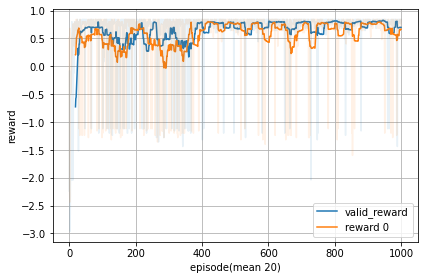

100エピソードの平均結果 0.7411999999999999


In [11]:
import srl
from srl.runner import sequence

config = sequence.Config(
    env_config=srl.envs.Config("Grid"),
    rl_config=MyConfig(),
)

# --- train
parameter, remote_memory, history = sequence.train(config, max_episodes=1000)
history.plot()

# --- test
rewards = sequence.evaluate(config, parameter, max_episodes=100)
print("100エピソードの平均結果", np.mean(rewards))


In [12]:
reward, render = sequence.render(config, parameter, enable_animation=True)


### 0
......
.   G.
. . X.
.P   .
......

 ←: 0.28570
 ↓: 0.24575
 →: 0.22729
*↑: 0.39706
### 1, actions [3], rewards [-0.04], done False(), next [0]
......
.   G.
.P. X.
.    .
......

env_info  : {}
work_info 0: None
train_info: None
 ←: 0.36459
 ↓: 0.28456
 →: 0.37185
*↑: 0.51814
### 2, actions [3], rewards [-0.04], done False(), next [0]
......
.   G.
.P. X.
.    .
......

env_info  : {}
work_info 0: {}
train_info: None
 ←: 0.36459
 ↓: 0.28456
 →: 0.37185
*↑: 0.51814
### 3, actions [3], rewards [-0.04], done False(), next [0]
......
.P  G.
. . X.
.    .
......

env_info  : {}
work_info 0: {}
train_info: None
 ←: 0.39277
 ↓: 0.36959
*→: 0.62524
 ↑: 0.44154
### 4, actions [2], rewards [-0.04], done False(), next [0]
......
.P  G.
. . X.
.    .
......

env_info  : {}
work_info 0: {}
train_info: None
 ←: 0.39277
 ↓: 0.36959
*→: 0.62524
 ↑: 0.44154
### 5, actions [2], rewards [-0.04], done False(), next [0]
......
. P G.
. . X.
.    .
......

env_info  : {}
work_info 0: {}
train_info: N

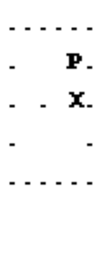

In [13]:
# render.create_anime(fps=2).save("MyRL-FrozenLake.gif")
render.display(fps=2)
